# Purpose

This notebook will use some basic ML code to attempt to identify the driver corresponding to a randomly selected telemetry trace.  Currently this is extremely early stages, so we will see how well that works!

# Method

Telemetry traces will be accessed for a given track using the fastf1 package.  These will be used to train the NN.  Finally, I will test the data using data not used in the training data. 

I am considering testing this in a few ways:

- Train on 1 race, test on same race
- Train on 1 race, test on different race
- Train on all races, test on any race
- Train on rualifying, test on race

# Purpose

This notebook will use some basic ML code to attempt to identify the driver corresponding to a randomly selected telemetry trace.  Currently this is extremely early stages, so we will see how well that works!

# Method

Telemetry traces will be accessed for a given track using the fastf1 package.  These will be used to train the NN.  Finally, I will test the data using data not used in the training data. 

I am considering testing this in a few ways:

- Train on 1 race, test on same race
- Train on 1 race, test on different race
- Train on all races, test on any race
- Train on rualifying, test on race

In [2]:
import os
import sys

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib import cm
%matplotlib widget

import fastf1
import fastf1.plotting
fastf1.Cache.enable_cache(os.environ['f1_cache'])  

from tensorflow import keras
import keras_tuner

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

plt.ion()



In [3]:
# Get speed traces for Max in Abu Dhabi 2022 GP

session = fastf1.get_session(2022, 'Abu Dhabi', 'R')
session.load()
driver_laps = session.laps.pick_driver('VER')

core           INFO 	Loading data for Abu Dhabi Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '16', '11', '55', '63', '4', '31', '18', '3', '5', '22', '24', '23', '10', '77', '47', '20', '44', '6', '14']


In [72]:
# Clean laps considered to laps without pitstop

driver_laps = driver_laps[np.logical_and(driver_laps.PitOutTime.isna(), driver_laps.PitInTime.isna())]

In [80]:
# Interpolate lap information for consistent timing
# This cell should be turned into a function so that it can be easily applied for multiple drivers/sessions.  

sample_interval_seconds = 0.1
sample_interval_seconds_str = '{}S'.format(sample_interval_seconds)

max_time_seconds = driver_laps['LapTime'].max().value/1e9 # Get max lap time in seconds.
n_samples = int(2**np.ceil(np.log2(max_time_seconds/sample_interval_seconds)))#np.ceil(max_time_seconds/sample_interval_seconds)
time_index = (np.arange(n_samples))*np.timedelta64(int(sample_interval_seconds*1000),'ms')

refined_laps = pd.DataFrame(index=time_index,columns=range(n_samples))

print('Cleaning Laps')
for i, (lap_index, lap) in enumerate(driver_laps.iterlaps()):
    print('On lap {}/{}'.format(i+1,len(driver_laps)), end="\r")
    telem_data = lap.get_telemetry()
    ts = pd.Series(telem_data['Speed'].values, index=telem_data['Time'])
    rs = ts.resample(sample_interval_seconds_str, kind='timestamp').mean().interpolate(method='linear').ewm(span = 3).mean().reindex(time_index) # Smoothed and interpolated series, was also shifting using .shift(-0.5,freq=sample_interval_seconds_str), however I wanted it to start at 0 and it didn't matter.
    refined_laps[i] = rs


Cleaning Laps


Time
0 days 00:00:00           227.000000
0 days 00:00:00.100000    229.000000
0 days 00:00:00.200000    230.714286
0 days 00:00:00.300000    232.466667
0 days 00:00:00.400000    234.118280
                             ...    
0 days 00:01:39.500000           NaN
0 days 00:01:39.600000           NaN
0 days 00:01:39.700000           NaN
0 days 00:01:39.800000           NaN
0 days 00:01:39.900000           NaN
Length: 1000, dtype: float64


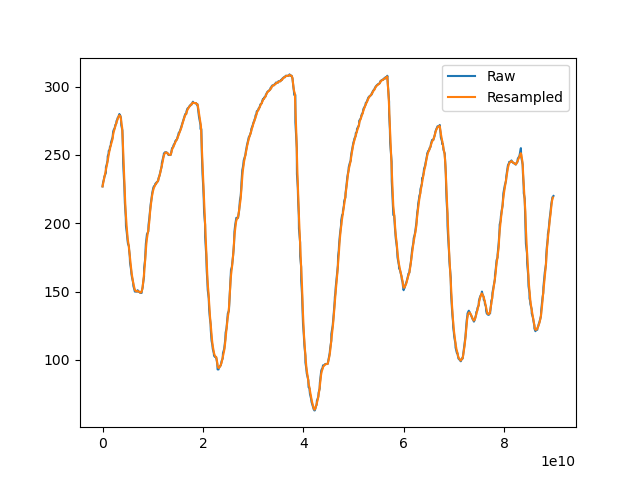

In [74]:
# Compare raw data to most recently called resampled lap.
plt.figure()
plt.plot(ts, label='Raw')
plt.plot(rs, label='Resampled')
# plt.plot(rs.shift(0.5, freq='0.05S'), label='Shifted')
plt.legend()
# # print(ts)
print(rs.head(1000))


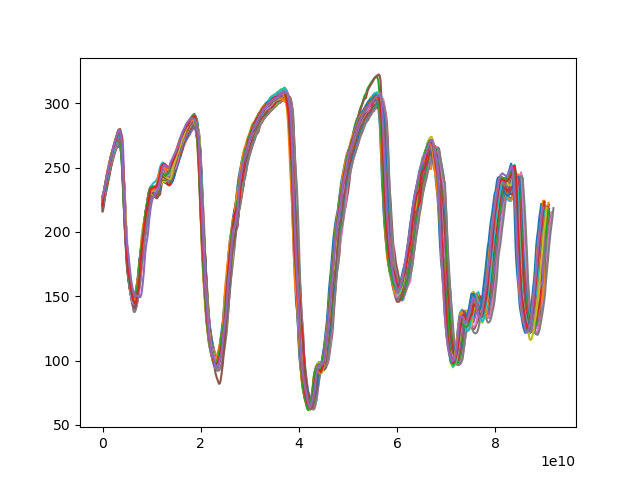

In [76]:
# Quickly plot laps
plt.figure()

for (lap_index, lap_data) in refined_laps.iteritems():
    plt.plot(lap_data, label=lap_index)

# print(refined_laps)

### Status
At this point we have obtained a set of consistently formatted (sampled equally in time and of equal length) speed traces.